In [1]:
import sys
sys.path.append('../')
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.geometric import Geometric
from Code.envs.storerecall import make_batch
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from PIL import Image
import numpy as np

In [2]:
BATCH_SIZE = 128

USE_JIT = False

#TODO: test device
device = torch.device('cpu')


In [3]:
spec2 = {'beta': 0.9,
   'lr': 0.001,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 1,
   'spkfn': 'ss',
   'decay_out': False,
   'architecture': '1L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Cooldown'}

spec = {'beta': 0.9,
   'lr': 0.01,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 0.95,
   'spkfn': 'bellec',
   'decay_out': False,
   'architecture': '2L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Adaptive'}

spec['iterations'] = 1000
#spec['mem_beta'] = 0.9985
spec['mem_neuron'] = 'FlipFlop'

In [4]:
from Code.Networks2 import Selector, DynNetwork, OuterWrapper, LSTMWrapper, ReLuWrapper, DummyNeuron, SequenceWrapper, ParallelNetwork, MeanModule
from Code.NewNeurons2 import SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron, AdaptiveNeuron, FlipFlopNeuron


built_config = {
    'BETA': spec['beta'],
    'OFFSET': 7, # TODO: was 3 for config24
    'SPIKE_FN': spec['spkfn'],
    '1-beta': spec['1-beta'],
    'ADAPDECAY': 0.9985,
    'ADAPSCALE': 180
}

#TODO: changed here
built_config['ADAPDECAY'] = 0.99

mem_config = {
    **built_config,
    'BETA': spec['mem_beta']
}

n_input = 3
n_control = 10
n_mem = 10

control_lookup = {
    'LIF': LIFNeuron,
    'Disc': SeqOnlySpike,
    'NoReset': NoResetNeuron
}

mem_lookup = {
    'Adaptive': AdaptiveNeuron,
    'Cooldown': CooldownNeuron,
    'NoReset': NoResetNeuron,
    'FlipFlop': FlipFlopNeuron
}

control_neuron = control_lookup[spec['control_neuron']](n_control, built_config)
mem_neuron = mem_lookup[spec['mem_neuron']](n_mem, mem_config)
out_neuron = OutputNeuron(n_control+n_mem, built_config) if spec['decay_out'] else DummyNeuron(n_control+n_mem, built_config)


loop_2L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_1L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop = loop_1L if spec['architecture'] == '1L' else loop_2L

outer = OrderedDict([
    ('input', n_input),
    ('loop', [['input'], SequenceWrapper(ParallelNetwork(loop, bias=(not spec['NoBias']))), None]),
    ('output', [['loop'], DummyNeuron(1, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device)


#loop_model = OuterWrapper(make_SequenceWrapper(ParallelNetwork(loop), USE_JIT), device, USE_JIT)

#final_linear = nn.Linear(n_control+n_mem, 10).to(device)
'''
if spec['ported_weights']:
    o_weights = pickle.load(open('weight_transplant_enc', 'rb'))

    o1 = torch.tensor(o_weights['RecWeights/RecurrentWeight:0']).t()
    o2 = torch.tensor(o_weights['InputWeights/InputWeight:0']).t()
    o3 = torch.cat((o2, o1), dim=1)
    with torch.no_grad():
        model.pretrace.layers.loop.model.layers.control_synapse.weight.data[:,:300] = o3[:120] if spec['architecture'] == '1L' else o3[:120, :181]
        model.pretrace.layers.loop.model.layers.mem_synapse.weight.data[:,:300] = o3[120:] if spec['architecture'] == '1L' else o3[120:, 180:]
        model.pretrace.layers.output_synapse.weight.data = torch.tensor(o_weights['out_weight:0']).t()
'''
params = list(model.parameters())

model.to(device)


OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (loop): SequenceWrapper(
        (model): ParallelNetwork(
          (layers): ModuleDict(
            (control_synapse): Linear(in_features=13, out_features=10, bias=False)
            (control): LIFNeuron()
            (mem_synapse): Linear(in_features=10, out_features=10, bias=False)
            (mem): FlipFlopNeuron()
            (output): DummyNeuron()
          )
        )
      )
      (output_synapse): Linear(in_features=20, out_features=1, bias=True)
      (output): DummyNeuron()
    )
  )
)

In [5]:
lr = spec['lr']
optimizer = optim.Adam(params, lr=lr)
bce = nn.BCEWithLogitsLoss(reduction='none')

ITERATIONS = spec['iterations']#36000

In [6]:
stats = {
    'grad_norm': [],
    'loss': [],
    'acc': [],
    'batch_var': [],
    'val': []
}

grad_norm_history = []
def record_norm():
    norms = []
    for p in params:
        norms.append(p.grad.norm().item())
    stats['grad_norm'].append(torch.tensor(norms).norm().item())


In [7]:
store_dist = (lambda : Geometric(torch.tensor([0.2], device=device)).sample().int().item()+1)
recall_dist = (lambda : Geometric(torch.tensor([0.2], device=device)).sample().int().item()+1)
SEQ_LEN = 13
CHAR_DUR = 100 #100

In [8]:
start = time.time()
i = 1
sumloss = 0
sumacc = 0

while i < ITERATIONS:
    batchstart = time.time()
    optimizer.zero_grad()
    data = make_batch(BATCH_SIZE, SEQ_LEN, store_dist, recall_dist, device)
    #data = data.repeat_interleave(CHAR_DUR, 0)
    input = data[:, :, :3]
    target = data[:, :, 3]
    recall = data[:, :, 0]

    input = input.repeat_interleave(CHAR_DUR, 0)
    #TODO: repeat data over

    output, _ = model(input)
    output = output.squeeze()
    output = output.view(SEQ_LEN, CHAR_DUR, BATCH_SIZE).mean(dim=1)
    assert output.shape == target.shape, f'shapes on loss {output.shape}, {target.shape}'
    #TODO: mask with recall
    loss = (bce(output, target)*recall).sum()/recall.sum() #correct shape?
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        record_norm()
        stats['loss'].append(loss.item())
        acc = ((((output > 0).float() == target).float()*recall).sum()/recall.sum()).item()
        #stats['acc'].append(acc)
        batch_var = 3 #out_final.var(0).mean().item()
        #stats['batch_var'].append(batch_var)

        print(loss.item(), acc)


    sumloss += loss.item()
    sumacc += acc
    if i%20 == 0:
        print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, batch_var) #torch.argmax(outputs[-1], 1).float().var()
        sumloss = 0
        sumacc = 0
    if i%2500 == 0:
        lr = lr * spec['lr_decay']
        optimizer = optim.Adam(params, lr=lr)
        print('Learning Rate: ', lr)
    i += 1
    #config['stats'] = stats
    #config['progress'] = i
    #with open('configs/' + run_id + '.json', 'w') as config_file:
    #    json.dump(config, config_file, indent=2)
    #model.save('models/'+run_id)


print('Total time: ', time.time()-start)


0.7128432989120483 0.4771241843700409
0.6982658505439758 0.4938271641731262
0.6957652568817139 0.42352941632270813
0.6952494382858276 0.4523809552192688
0.6933560371398926 0.49418604373931885
0.69258052110672 0.5481927990913391
0.6933420896530151 0.48571428656578064
0.6930007934570312 0.543749988079071
0.693238377571106 0.4702380895614624
0.6769970655441284 0.84375
0.6759311556816101 0.5361445546150208
0.6718695759773254 0.47093021869659424
0.6878449320793152 0.523809552192688
0.6852061748504639 0.6024844646453857
0.6709387898445129 0.6951219439506531
0.6660746335983276 0.7228915691375732
0.6500115990638733 0.8074533939361572
0.6551989912986755 0.7852760553359985
0.6159607172012329 0.957317054271698
0.6335474252700806 0.8779069781303406
0.6335474252700806 0.6778611361980438 0.6106014356017113 5.497873067855835 3
0.6002939939498901 0.954023003578186
0.5649377107620239 0.915730357170105
0.5415499806404114 0.9290322661399841
0.5288442969322205 0.9390243887901306
0.6365069150924683 0.66874

In [9]:
test_data = make_batch(1, 13, store_dist, recall_dist, device)

In [10]:
a = test_data[:, 0 ,0].nonzero()

In [11]:
b = test_data[:a, 0, 1].nonzero()[-1]

In [12]:
test_data[b, 0, 2] == test_data[a, 0, 3]


tensor([[True]])

In [13]:
data = make_batch(BATCH_SIZE, SEQ_LEN, store_dist, recall_dist, device)
data = data.repeat_interleave(CHAR_DUR, 0)
input = data[:, :, :3]
target = data[:, :, 3]
recall = data[:, :, 0]
#TODO: repeat data over

with torch.no_grad():
    output, _, log = model(input, logging=True)

In [14]:
ab = (log['loop']['control'][:, 0] * 255).t().numpy().astype(np.uint8)

In [15]:
ar_length = input.shape[0]
array_list = [input, log['loop']['control'], log['loop']['mem'], log['output']] #log['loop']['output']
array_list2 = []
for ar in array_list:
    array_list2.append(ar[:, 0])
    array_list2.append(torch.ones((ar_length, 1), device=input.device) * 0.5)
big_ar = torch.cat(array_list2[:-1], dim=1).detach() * 255
img = Image.fromarray(big_ar.numpy().astype(np.uint8), 'L')

In [16]:
img.size

(27, 1300)

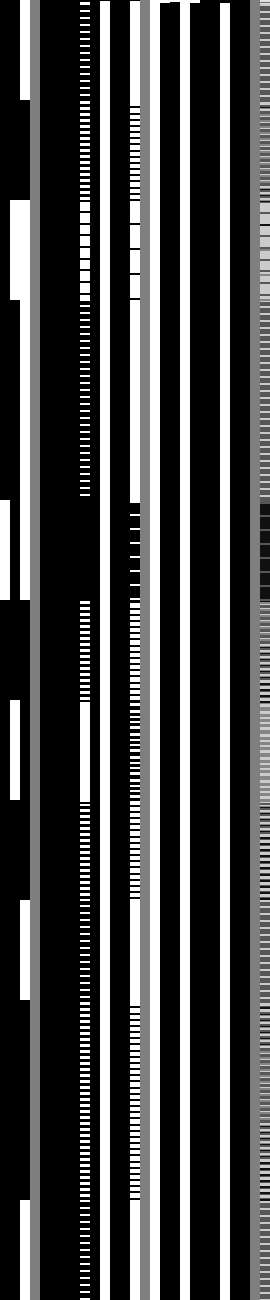

In [17]:
img.resize((27*10, 1300))